In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [31]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
using Test
using ForwardDiff
using SpecialFunctions
using Polynomials
using BenchmarkTools
using TransportMap
using QuadGK
using FastGaussQuadrature
using AdaptiveTransportMap: derivative, vander
using DiffResults
using QuadGK
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


### Hermite functions

In [45]:
@time integral, err = quadgk(x -> FamilyPhyHermite[5](x), 1.0, 12.0, rtol=1e-8)

  0.096975 seconds (169.61 k allocations: 9.014 MiB)


(14.476767500482348, 3.9936307363668854e-8)

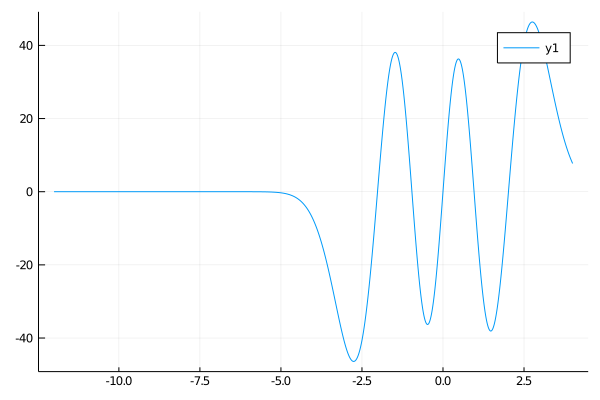

In [37]:
plot(collect(-12.0:0.01:4.0), PhyHermite(5).(collect(-12.0:0.01:4.0)))

In [46]:
derivative(FamilyPhyHermite[5], -1, [1.0])

1-element Array{Float64,1}:
 -18.84597896350062

In [48]:
@testset "Verify 1st derivative of Probabilistic hermite functions" begin

    x = randn(100)
    m = 5
    dV = vander(ProHermite(m), 1, x; scaled = false)

    for i=0:5
        @test norm(dV[:,i+1] - (FamilyProPolyHermite[i+1].(x) .* (-0.5*x) .* exp.(-x.^2/4) +
            derivative(FamilyProPolyHermite[i+1],1).(x) .* exp.(-x.^2/4)))<1e-8
    end
end

Test Summary:                                            | Pass  Total
Verify 1st derivative of Probabilistic hermite functions |    6      6


Test.DefaultTestSet("Verify 1st derivative of Probabilistic hermite functions", Any[], 6, false)

In [49]:
@testset "Verify second derivative of Probabilistic hermite functions" begin

    x = randn(100)
    m = 5
    dV = vander(ProHermite(m), 2, x; scaled = false)

    for i=0:5
        Hen = FamilyProPolyHermite[i+1].(x)
        Henp = derivative(FamilyProPolyHermite[i+1],1).(x)
        Henpp = derivative(FamilyProPolyHermite[i+1],2).(x)
        E = exp.(-x.^2/4)

        @test norm(dV[:,i+1] - (Henpp .*E - x .* Henp.*E + 0.5*Hen .* (0.5*x.^2 .- 1.0) .* E))<1e-8
    end
end

Test Summary:                                               | Pass  Total
Verify second derivative of Probabilistic hermite functions |    6      6


Test.DefaultTestSet("Verify second derivative of Probabilistic hermite functions", Any[], 6, false)

In [20]:
# @testset "Verify evaluation of Physicist hermite functions" begin


x = randn(100)
m = 5
dV = vander(PhyHermite(m), 2, x; scaled = false)

for i=0:5
    Hn = FamilyPhyPolyHermite[i+1].(x)
    Hnp = derivative(FamilyPhyPolyHermite[i+1],1).(x)
    Hnpp = derivative(FamilyPhyPolyHermite[i+1],2).(x)
    E = exp.(-x.^2/2)
    
    @test norm(dV[:,i+1] - (Hnpp .*E -2 .*x .* Hnp.*E + Hn .* (x.^2 .- 1.0) .* E))<1e-8
end

### Rescale variables

In [24]:
### Rescale variable 
ens = EnsembleState(randn(100,1000))
x̄ = mean(ens)
S = cov(ens) + 20*I
C = cholesky(S)
@time inv(C.L)

UndefVarError: UndefVarError: cov not defined

In [25]:
?ldiv!

search: ldiv! splitdrive



```
ldiv!(Y, A, B) -> Y
```

Compute `A \ B` in-place and store the result in `Y`, returning the result.

The argument `A` should *not* be a matrix.  Rather, instead of matrices it should be a factorization object (e.g. produced by [`factorize`](@ref) or [`cholesky`](@ref)). The reason for this is that factorization itself is both expensive and typically allocates memory (although it can also be done in-place via, e.g., [`lu!`](@ref)), and performance-critical situations requiring `ldiv!` usually also require fine-grained control over the factorization of `A`.

# Examples

```jldoctest
julia> A = [1 2.2 4; 3.1 0.2 3; 4 1 2];

julia> X = [1; 2.5; 3];

julia> Y = zero(X);

julia> ldiv!(Y, qr(A), X);

julia> Y
3-element Array{Float64,1}:
  0.7128099173553719
 -0.051652892561983674
  0.10020661157024757

julia> A\X
3-element Array{Float64,1}:
  0.7128099173553719
 -0.05165289256198333
  0.10020661157024785
```

---

```
ldiv!(A, B)
```

Compute `A \ B` in-place and overwriting `B` to store the result.

The argument `A` should *not* be a matrix.  Rather, instead of matrices it should be a factorization object (e.g. produced by [`factorize`](@ref) or [`cholesky`](@ref)). The reason for this is that factorization itself is both expensive and typically allocates memory (although it can also be done in-place via, e.g., [`lu!`](@ref)), and performance-critical situations requiring `ldiv!` usually also require fine-grained control over the factorization of `A`.

# Examples

```jldoctest
julia> A = [1 2.2 4; 3.1 0.2 3; 4 1 2];

julia> X = [1; 2.5; 3];

julia> Y = copy(X);

julia> ldiv!(qr(A), X);

julia> X
3-element Array{Float64,1}:
  0.7128099173553719
 -0.051652892561983674
  0.10020661157024757

julia> A\Y
3-element Array{Float64,1}:
  0.7128099173553719
 -0.05165289256198333
  0.10020661157024785
```

---

```
ldiv!(a::Number, B::AbstractArray)
```

Divide each entry in an array `B` by a scalar `a` overwriting `B` in-place.  Use [`rdiv!`](@ref) to divide scalar from right.

# Examples

```jldoctest
julia> B = [1.0 2.0; 3.0 4.0]
2×2 Array{Float64,2}:
 1.0  2.0
 3.0  4.0

julia> ldiv!(2.0, B)
2×2 Array{Float64,2}:
 0.5  1.0
 1.5  2.0
```

---

Solve Hy = rhs for a non-square Hessenberg matrix. Note that `H` is also modified as is it converted to an upper triangular matrix via Given's rotations


In [26]:
?cholesky

search: cholesky cholesky! Cholesky CholeskyPivoted



```
cholesky(A, Val(false); check = true) -> Cholesky
```

Compute the Cholesky factorization of a dense symmetric positive definite matrix `A` and return a `Cholesky` factorization. The matrix `A` can either be a [`Symmetric`](@ref) or [`Hermitian`](@ref) `StridedMatrix` or a *perfectly* symmetric or Hermitian `StridedMatrix`. The triangular Cholesky factor can be obtained from the factorization `F` with: `F.L` and `F.U`. The following functions are available for `Cholesky` objects: [`size`](@ref), [`\`](@ref), [`inv`](@ref), [`det`](@ref), [`logdet`](@ref) and [`isposdef`](@ref).

When `check = true`, an error is thrown if the decomposition fails. When `check = false`, responsibility for checking the decomposition's validity (via [`issuccess`](@ref)) lies with the user.

# Examples

```jldoctest
julia> A = [4. 12. -16.; 12. 37. -43.; -16. -43. 98.]
3×3 Array{Float64,2}:
   4.0   12.0  -16.0
  12.0   37.0  -43.0
 -16.0  -43.0   98.0

julia> C = cholesky(A)
Cholesky{Float64,Array{Float64,2}}
U factor:
3×3 UpperTriangular{Float64,Array{Float64,2}}:
 2.0  6.0  -8.0
  ⋅   1.0   5.0
  ⋅    ⋅    3.0

julia> C.U
3×3 UpperTriangular{Float64,Array{Float64,2}}:
 2.0  6.0  -8.0
  ⋅   1.0   5.0
  ⋅    ⋅    3.0

julia> C.L
3×3 LowerTriangular{Float64,Array{Float64,2}}:
  2.0   ⋅    ⋅
  6.0  1.0   ⋅
 -8.0  5.0  3.0

julia> C.L * C.U == A
true
```

---

```
cholesky(A, Val(true); tol = 0.0, check = true) -> CholeskyPivoted
```

Compute the pivoted Cholesky factorization of a dense symmetric positive semi-definite matrix `A` and return a `CholeskyPivoted` factorization. The matrix `A` can either be a [`Symmetric`](@ref) or [`Hermitian`](@ref) `StridedMatrix` or a *perfectly* symmetric or Hermitian `StridedMatrix`. The triangular Cholesky factor can be obtained from the factorization `F` with: `F.L` and `F.U`. The following functions are available for `CholeskyPivoted` objects: [`size`](@ref), [`\`](@ref), [`inv`](@ref), [`det`](@ref), and [`rank`](@ref). The argument `tol` determines the tolerance for determining the rank. For negative values, the tolerance is the machine precision.

When `check = true`, an error is thrown if the decomposition fails. When `check = false`, responsibility for checking the decomposition's validity (via [`issuccess`](@ref)) lies with the user.

---

```
cholesky(A; shift = 0.0, check = true, perm = nothing) -> CHOLMOD.Factor
```

Compute the Cholesky factorization of a sparse positive definite matrix `A`. `A` must be a [`SparseMatrixCSC`](@ref) or a [`Symmetric`](@ref)/[`Hermitian`](@ref) view of a `SparseMatrixCSC`. Note that even if `A` doesn't have the type tag, it must still be symmetric or Hermitian. If `perm` is not given, a fill-reducing permutation is used. `F = cholesky(A)` is most frequently used to solve systems of equations with `F\b`, but also the methods [`diag`](@ref), [`det`](@ref), and [`logdet`](@ref) are defined for `F`. You can also extract individual factors from `F`, using `F.L`. However, since pivoting is on by default, the factorization is internally represented as `A == P'*L*L'*P` with a permutation matrix `P`; using just `L` without accounting for `P` will give incorrect answers. To include the effects of permutation, it's typically preferable to extract "combined" factors like `PtL = F.PtL` (the equivalent of `P'*L`) and `LtP = F.UP` (the equivalent of `L'*P`).

When `check = true`, an error is thrown if the decomposition fails. When `check = false`, responsibility for checking the decomposition's validity (via [`issuccess`](@ref)) lies with the user.

Setting the optional `shift` keyword argument computes the factorization of `A+shift*I` instead of `A`. If the `perm` argument is provided, it should be a permutation of `1:size(A,1)` giving the ordering to use (instead of CHOLMOD's default AMD ordering).

# Examples

In the following example, the fill-reducing permutation used is `[3, 2, 1]`. If `perm` is set to `1:3` to enforce no permutation, the number of nonzero elements in the factor is 6.

```jldoctest
julia> A = [2 1 1; 1 2 0; 1 0 2]
3×3 Array{Int64,2}:
 2  1  1
 1  2  0
 1  0  2

julia> C = cholesky(sparse(A))
SuiteSparse.CHOLMOD.Factor{Float64}
type:    LLt
method:  simplicial
maxnnz:  5
nnz:     5
success: true

julia> C.p
3-element Array{Int64,1}:
 3
 2
 1

julia> L = sparse(C.L);

julia> Matrix(L)
3×3 Array{Float64,2}:
 1.41421   0.0       0.0
 0.0       1.41421   0.0
 0.707107  0.707107  1.0

julia> L * L' ≈ A[C.p, C.p]
true

julia> P = sparse(1:3, C.p, ones(3))
3×3 SparseMatrixCSC{Float64,Int64} with 3 stored entries:
  [3, 1]  =  1.0
  [2, 2]  =  1.0
  [1, 3]  =  1.0

julia> P' * L * L' * P ≈ A
true

julia> C = cholesky(sparse(A), perm=1:3)
SuiteSparse.CHOLMOD.Factor{Float64}
type:    LLt
method:  simplicial
maxnnz:  6
nnz:     6
success: true

julia> L = sparse(C.L);

julia> Matrix(L)
3×3 Array{Float64,2}:
 1.41421    0.0       0.0
 0.707107   1.22474   0.0
 0.707107  -0.408248  1.1547

julia> L * L' ≈ A
true
```

!!! note
    This method uses the CHOLMOD library from SuiteSparse, which only supports doubles or complex doubles. Input matrices not of those element types will be converted to `SparseMatrixCSC{Float64}` or `SparseMatrixCSC{ComplexF64}` as appropriate.

    Many other functions from CHOLMOD are wrapped but not exported from the `Base.SparseArrays.CHOLMOD` module.

